In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from collections import Counter
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
import pickle

In [137]:
df = pd.read_csv('https://raw.githubusercontent.com/dsrscientist/dataset3/main/glass.csv')

In [3]:
df.head()

,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.00.1,1.1
0,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
1,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
2,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
3,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
4,6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1


**It seems that the first observation is shifted to the column heading part.Column heading need to be added and shifting of observation to first row should be done to make a proper dataset**

In [4]:
df.shape

(213, 11)

In [138]:
df.columns = ['Id','RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type']  # adding column heading

In [139]:
 df.loc[-1] = [1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.00,1]  # adding a row
 df.index = df.index + 1  # shifting index
 df = df.sort_index()  # sorting by index

In [140]:
df.shape

(214, 11)

In [141]:
df.head()

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1.0
1,2.0,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1.0
2,3.0,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1.0
3,4.0,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1.0
4,5.0,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1.0


The dataset describes the chemical properties of glass and involves classifying samples of glass using their chemical properties as one of six classes. The dataset was credited to Vina Spiehler in 1987. The study of classification of types of glass was motivated by criminological investigation. At the scene of the crime, the glass left can be used as evidence...if it is correctly identified!

**The chemical compositions are measured as the weight percent in corresponding oxide**

In [9]:
# Removing the nominal data 'Id' inthe dataset

df.drop('Id',axis=1,inplace=True)

In [10]:
df.dtypes

RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type    float64
dtype: object

**Let's first summarize the distribution of the numerical variables**

In [11]:
df.columns

Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'], dtype='object')

In [12]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


The features are not on the same scale. For example Si has a mean of 72.65 while Ba has a mean value of 0.175. Let's go ahead and check the distribution of the glass types.

In [13]:
df['Type'].value_counts()

2.0    76
1.0    70
7.0    29
3.0    17
5.0    13
6.0     9
Name: Type, dtype: int64

The dataset seems imbalanced as class 1 & 2 constitutes almost 68% of the data

# Univariate Analysis

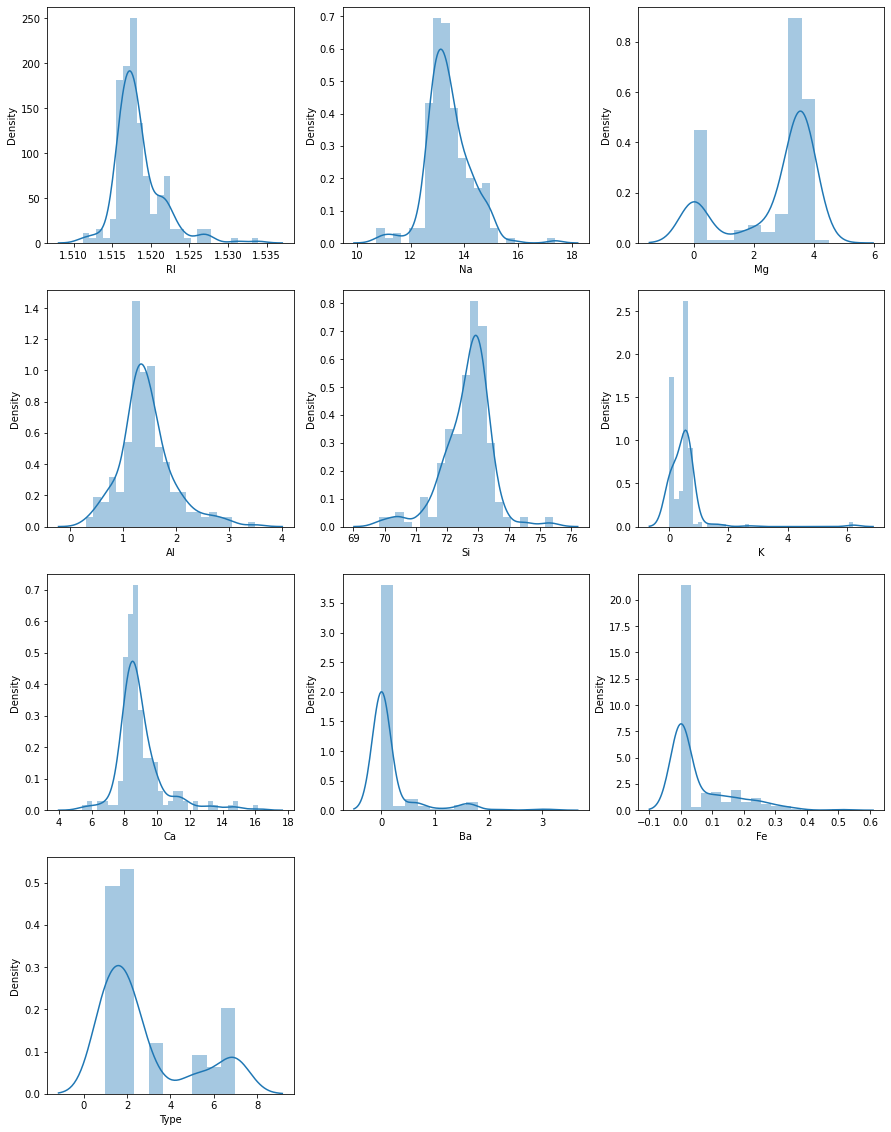

In [14]:
# Distribution plot
plt.figure(figsize = (15,20))
plotnumber=1

for column in df:
    if plotnumber<=11:
        ax = plt.subplot(4,3,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize =10)
    plotnumber+=1
plt.show()

**None of the features is normally distributed. The features Fe, Ba, Ca and K exhibit the highest skew coefficients.**

In [15]:
df.skew()

RI      1.625431
Na      0.454181
Mg     -1.152559
Al      0.907290
Si     -0.730447
K       6.551648
Ca      2.047054
Ba      3.416425
Fe      1.754327
Type    1.114915
dtype: float64

**Outcome of Skewness:**

Skewness threshold is taken as +/- 0.65. Columns having skewness:

* RI

* Mg

* Al

* Si

* K

* Ca

* Ba

* Fe

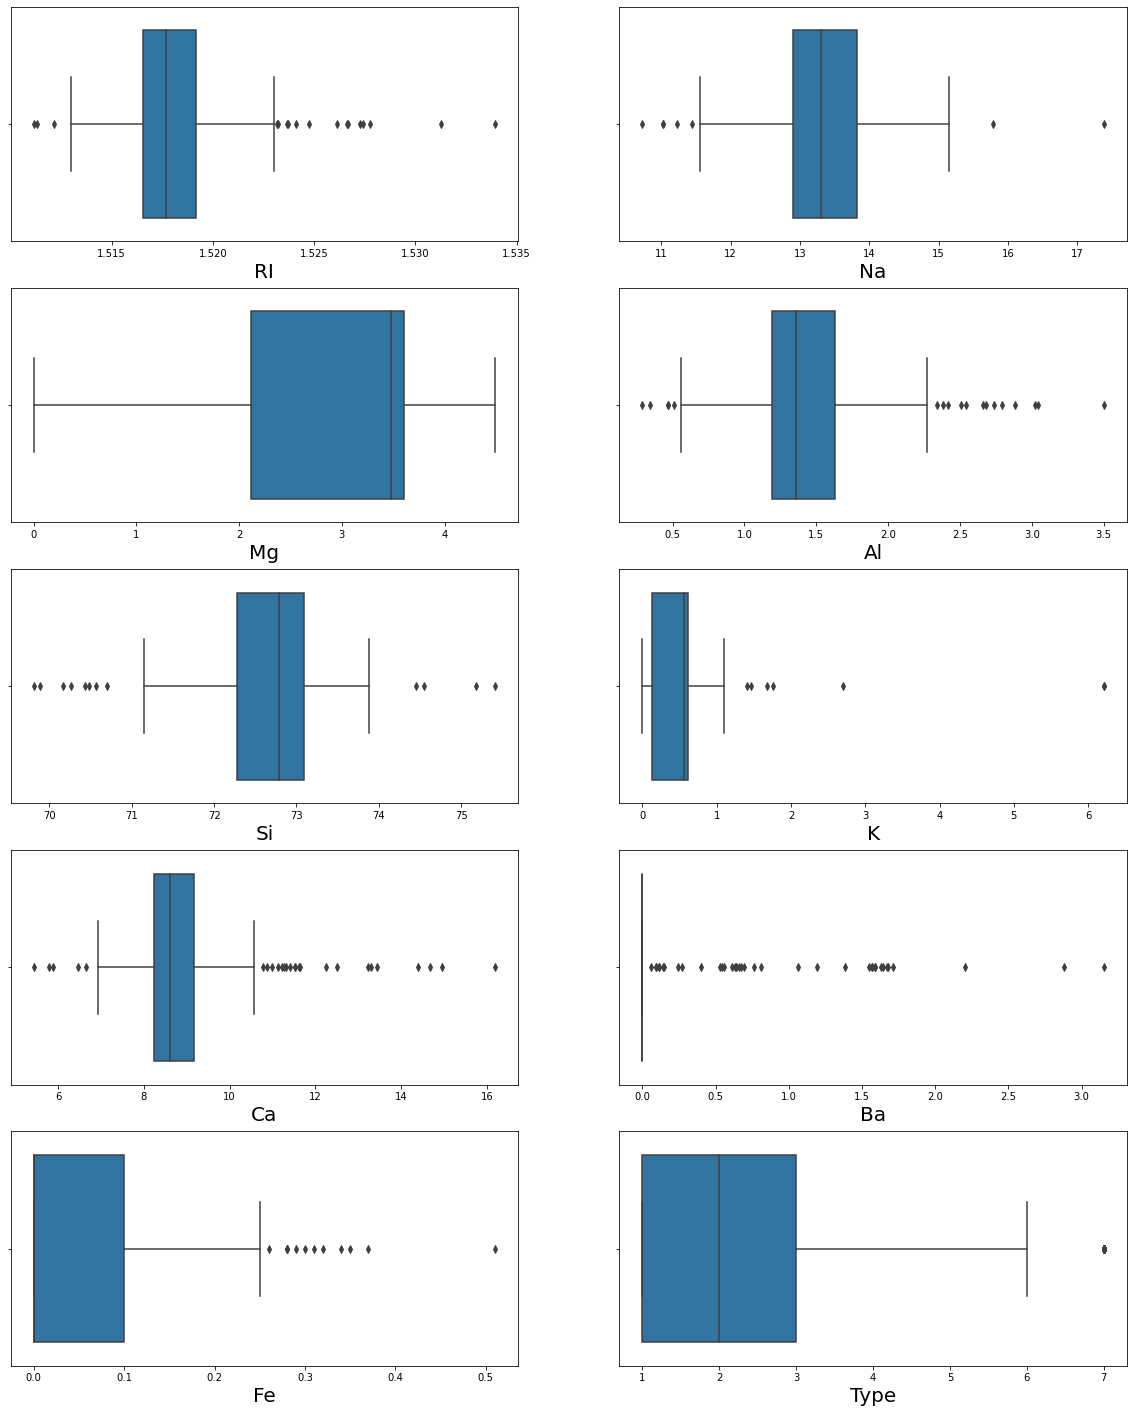

In [16]:
# Visualize the outliers using boxplot

plt.figure(figsize = (20,25))
graph = 1

for column in df:
    if graph <=10:
        plt.subplot(5,2,graph)
        ax=sns.boxplot(df[column])
        plt.xlabel(column,fontsize=20)
    graph+=1
plt.show()

**Silicon has a mean that is much superior to the other constituents as we already saw in the previous section. Well, that is normal since glass is mainly based on silica.**


**Outliers needs to be handled**

# Multivariate Analysis

In [17]:
features = df.columns[:-1].tolist()

In [18]:
features

['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

<Figure size 576x576 with 0 Axes>

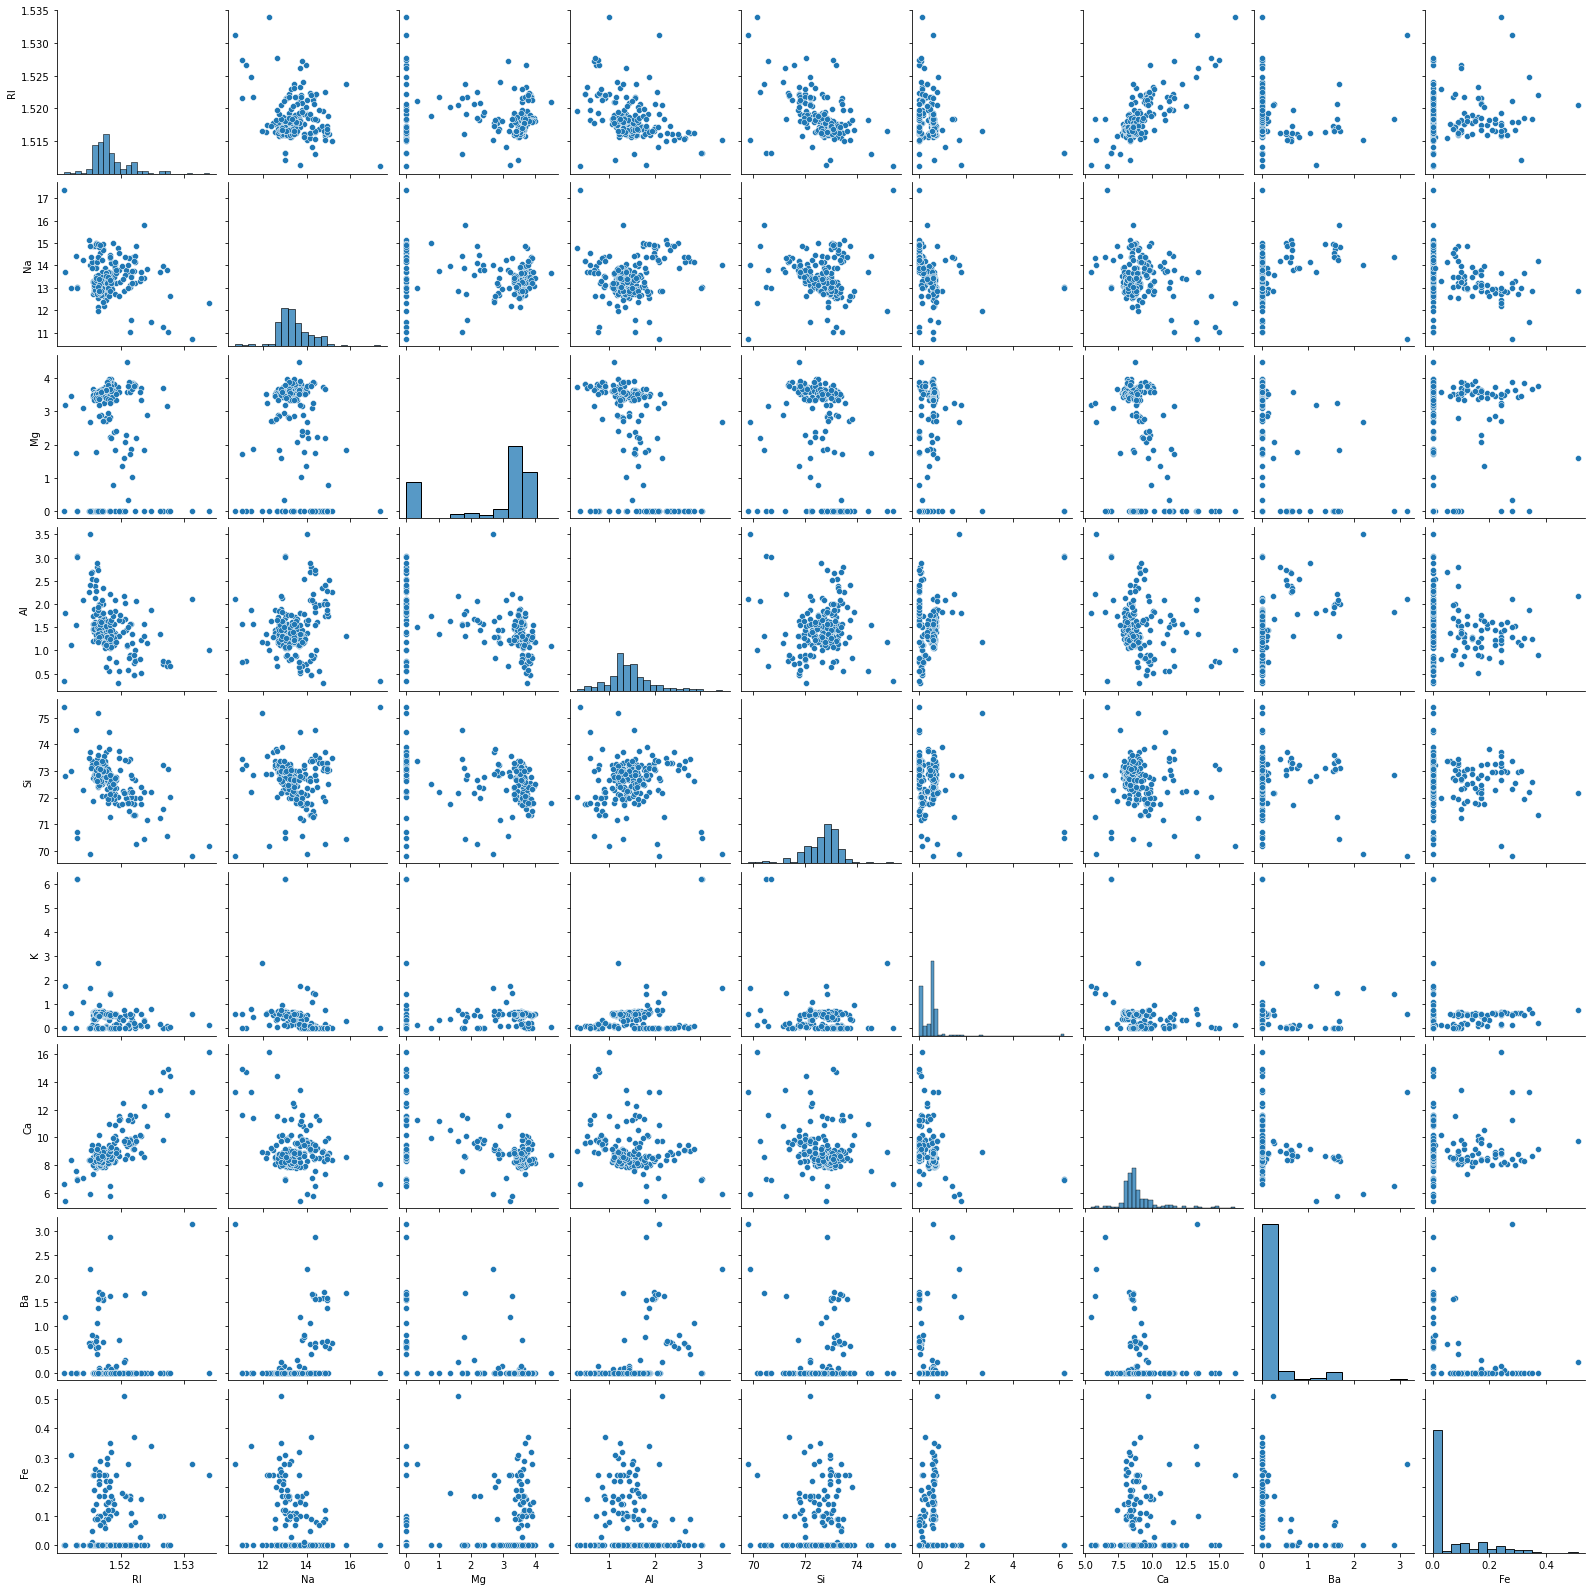

In [19]:
# Drawing a pairplot to visually examine the correlation between the features
plt.figure(figsize=(8,8))
sns.pairplot(df[features],palette='coolwarm')
plt.show()

Let's go ahead and examine a heatmap of the correlations

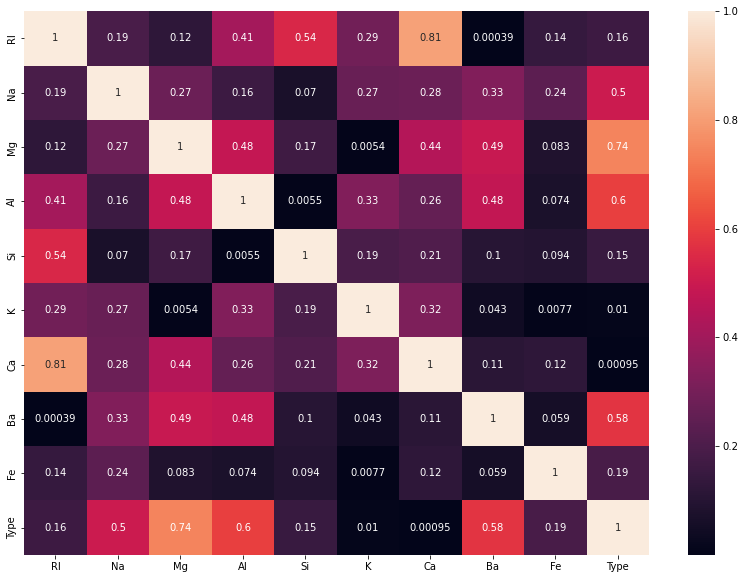

In [20]:
df_corr = df.corr().abs()

plt.figure(figsize = (14,10))

sns.heatmap(df_corr,annot = True,annot_kws = {'size':10})

plt.show()

There seems to be a strong positive correlation between RI and Ca. This could be a hint to perform Principal component analysis in order to decorrelate some of the input features.

# Data Pre-processing

In [21]:
df.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

**No missing values in the dataset. Good to proceed further**

In [22]:
# Considering skewness reduction through PowerTransformer

from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()

In [23]:
X = df.drop('Type',axis=1)
y = df['Type']

X_new_pt = pt.fit_transform(X)

In [24]:
# Converting numpy array(X_new_pt) into Dataframe and reassigning the values

X = pd.DataFrame(X_new_pt,columns= X.columns)

In [25]:
# Checking Skewness
X.skew().sort_values(ascending=False)

Ba    1.824175
Fe    0.858508
Si    0.130384
Al    0.000219
RI    0.000000
Na   -0.008973
K    -0.071816
Ca   -0.209314
Mg   -0.889528
dtype: float64

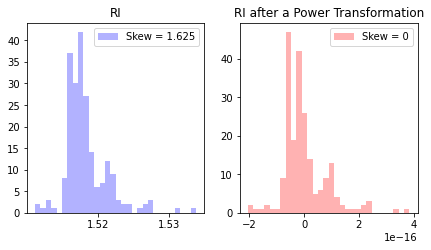

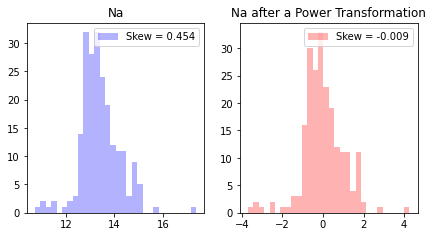

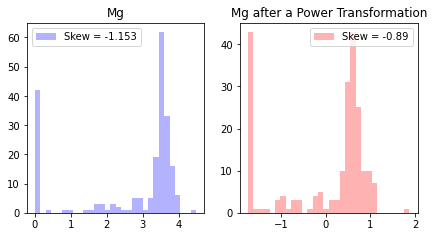

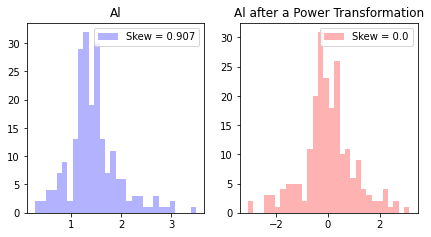

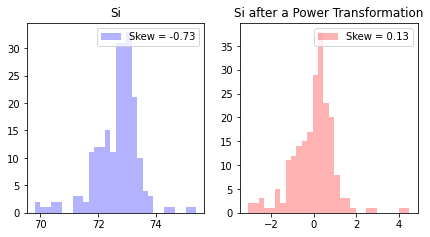

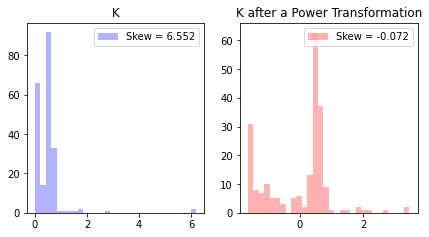

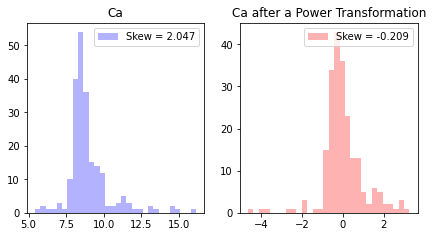

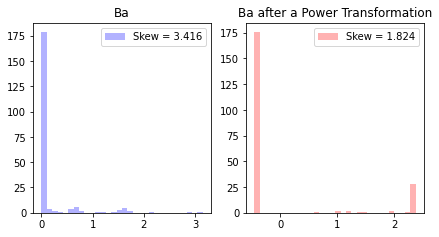

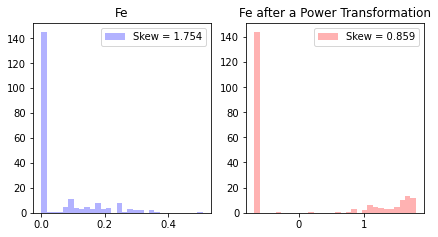

In [26]:
for feature in features:
    fig, ax = plt.subplots(1,2,figsize=(7,3.5))    
    ax[0].hist(df[feature], color='blue', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df[feature].skew(),3))) )
    ax[0].set_title(str(feature))   
    ax[0].legend(loc=0)
    ax[1].hist(X[feature], color='red', bins=30, alpha=0.3, label='Skew = %s' %(str(round(X[feature].skew(),3))) )
    ax[1].set_title(str(feature)+' after a Power Transformation')
    ax[1].legend(loc=0)
    plt.show()

The Powertransform seems to do a good job in reducing the skews of the different distributions of features. However, it does not lead to the normalization of the feature distributions.

**Next, let's explore dimensionality reduction techniques.**

# PCA

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

pca = PCA()

In [28]:
X_scaled = scaler.fit_transform(X)

pca.fit_transform(X_scaled)

array([[ 1.45521379,  0.10794011, -1.73173685, ..., -1.1743072 ,
        -0.36861019, -0.05773416],
       [-0.42547096, -0.87599949, -1.02062824, ...,  0.08391405,
        -0.34634457, -0.16509235],
       [-0.80784098, -1.02296358, -0.79233256, ..., -0.40001479,
        -0.3197817 ,  0.07523642],
       ...,
       [-2.28653226,  3.00674848,  0.04178994, ...,  0.15625464,
        -0.98577788, -0.19737563],
       [-2.97415866,  2.52444967, -0.231043  , ..., -0.0581504 ,
        -0.07959933,  0.08313226],
       [-2.80080996,  2.61920315,  0.05191366, ..., -0.24137706,
        -0.08453431,  0.13320668]])

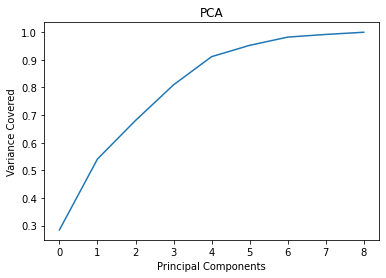

In [29]:
# Lets plot scree plot to check the best components

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Components')
plt.ylabel('Variance Covered')
plt.title('PCA')
plt.show()

**Around 6 components are able to explain >95% variance. Its safe to consider 6 PC's**

In [30]:
pca = PCA(n_components=6)
new_pcomp = pca.fit_transform(X_scaled)
princ_comp = pd.DataFrame(new_pcomp,columns=['PC1','PC2','PC3','PC4','PC5','PC6'])
princ_comp

,PC1,PC2,PC3,PC4,PC5,PC6
0,1.455214,0.107940,-1.731737,1.216950,-0.267231,0.560978
1,-0.425471,-0.875999,-1.020628,0.359597,-0.361855,-0.153193
2,-0.807841,-1.022964,-0.792333,-0.123133,-0.331471,-0.118988
3,0.133926,-1.101635,-0.520497,0.162913,-0.599887,0.169777
4,-0.117973,-1.150071,-0.699775,-0.358806,-0.429619,0.235240
...,...,...,...,...,...,...
209,-2.981219,2.570948,0.985163,0.449596,-0.491878,0.094175
210,-2.981343,2.750302,-0.432855,0.154082,0.140101,0.342793
211,-2.286532,3.006748,0.041790,-0.225923,-0.078636,0.945819
212,-2.974159,2.524450,-0.231043,-0.745521,0.186268,0.691412


# Target Variable

In [31]:
df['Type'].value_counts()

2.0    76
1.0    70
7.0    29
3.0    17
5.0    13
6.0     9
Name: Type, dtype: int64

**Type of glass: (class attribute)**

* 1-building_windows_float_processed
* 2- building_windows_non_float_processed
* 3- vehicle_windows_float_processed
* 4- vehicle_windows_non_float_processed (none in this database)
* 5- containers
* 6- tableware
* 7- headlamps

In [32]:
#  dividing the dataset into window glass (classes 1-4) as 1 and non-window glass (classes 5-7) as 0
# means window glass (1) and non window glass (0)

df['Type']=df['Type'].replace({1:1,2:1,5:0,6:0,3:1,4:1,7:0})

In [33]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1.0


In [34]:
df['Type'].value_counts()

1.0    163
0.0     51
Name: Type, dtype: int64

**The data is imbalanced and need to be balanced**

# Balancing target variable using SMOTE

In [35]:
from imblearn.over_sampling import SMOTE

In [49]:
X = df.drop('Type',axis=1)
y = df['Type']


**Oversampling of target data**

In [51]:
over_smp = SMOTE(0.75)
X_ns,y_ns = over_smp.fit_resample(X,y)

print("The number of target classes before fit {}".format(Counter(y)))

print("The number of target classes after fit{}".format(Counter(y_ns)))

The number of target classes before fit Counter({1.0: 163, 0.0: 51})
The number of target classes after fitCounter({1.0: 163, 0.0: 122})


# Function for model performance calculation

In [41]:
# Defining function for calculating the performance of the classification model
def metric_score(clf,X_train,X_test,y_train,y_test,train = True):
    if train:
        y_pred = clf.predict(X_train)
        
        print("-----------------Train Result--------------------")
        
        print(f"Accuracy Score : {accuracy_score(y_train,y_pred)*100:.2f}%")
        
    elif train == False:
        
        pred = clf.predict(X_test)
        
        print("-----------------Test Result--------------------")
        
        print(f"Accuracy Score : {accuracy_score(y_test,pred)*100:.2f}%")
        
        print("\n Test Classification Report \n ", classification_report(y_test,pred,digits =2))

# Best Random State

In [56]:
maxAccu = 0 # Max Accuracy
maxRS = 0   # Best random state for which maximum accuracy is achieved

for i in range(1,100):
    X_train,X_test,y_train,y_test = train_test_split(X_ns,y_ns,test_size=0.2,random_state=i)
    #lr = LogisticRegression()
    #dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    #knn = KNeighborsClassifier()
    #svc = SVC()
    #lr.fit(X_train,y_train)   # Training the model
    #dt.fit(X_train,y_train)
    rf.fit(X_train,y_train)
    #knn.fit(X_train,y_train)
    #svc.fit(X_train,y_train)
    #pred_lr = lr.predict(X_test)  # Predicting the target variable
    #pred_dt = dt.predict(X_test)
    pred_rf = rf.predict(X_test)
    #pred_knn = knn.predict(X_test)
    #pred_svc = svc.predict(X_test)
    #acc_lr = accuracy_score(y_test,pred_lr)
    #acc_dt = accuracy_score(y_test,pred_dt)
    acc_rf = accuracy_score(y_test,pred_rf)
    #acc_knn = accuracy_score(y_test,pred_knn)
    #acc_svc = accuracy_score(y_test,pred_svc)
    #print("Testing Accuracy: ",acc_lr,"at random state", i)
    #print("Testing Accuracy: ",acc_dt,"at random state", i)
    print("Testing Accuracy: ",acc_rf,"at random state", i)
    #print("Testing Accuracy: ",acc_knn,"at random state", i)
    #print("Testing Accuracy: ",acc_svc,"at random state", i)
    
    #if acc_lr>maxAccu:
    #if acc_dt>maxAccu:
    if acc_rf>maxAccu:
    #if acc_knn>maxAccu:
    #if acc_svc>maxAccu:
        #maxAccu = acc_lr
        #maxAccu = acc_dt
        maxAccu = acc_rf
        #maxAccu = acc_knn
        #maxAccu = acc_svc
        
        maxRS = i
        
        print("Maximum Accuracy:",maxAccu,"at random state ", maxRS)
        #print("Maximum Accuracy:",maxAccu,"at random state ", maxRS)

Testing Accuracy:  0.9649122807017544 at random state 1
Maximum Accuracy: 0.9649122807017544 at random state  1
Testing Accuracy:  0.9298245614035088 at random state 2
Testing Accuracy:  0.9473684210526315 at random state 3
Testing Accuracy:  0.9649122807017544 at random state 4
Testing Accuracy:  0.9824561403508771 at random state 5
Maximum Accuracy: 0.9824561403508771 at random state  5
Testing Accuracy:  0.9649122807017544 at random state 6
Testing Accuracy:  0.9824561403508771 at random state 7
Testing Accuracy:  0.9473684210526315 at random state 8
Testing Accuracy:  1.0 at random state 9
Maximum Accuracy: 1.0 at random state  9
Testing Accuracy:  0.9649122807017544 at random state 10
Testing Accuracy:  1.0 at random state 11
Testing Accuracy:  0.9824561403508771 at random state 12
Testing Accuracy:  0.9473684210526315 at random state 13
Testing Accuracy:  0.9649122807017544 at random state 14
Testing Accuracy:  0.9649122807017544 at random state 15
Testing Accuracy:  0.9649122807

In [57]:
#print("Best accuracy is ",maxAccu*100, "on random state", maxRS)
print("Best accuracy is ",maxAccu*100, "on random state", maxRS)

Best accuracy is  100.0 on random state 9


# Random Forest

In [89]:
X_train,X_test,y_train,y_test = train_test_split(X_ns,y_ns,test_size=0.2,random_state=9)  # Splitting into train test split on best random state

rf = RandomForestClassifier()  

rf.fit(X_train,y_train)      # Model training

pred_rf = rf.predict(X_test)    # Predicted values

matrix_rf = confusion_matrix(y_test,pred_rf)

print(matrix_rf)

metric_score(rf,X_train,X_test,y_train,y_test,train=True)  # Training result

metric_score(rf,X_train,X_test,y_train,y_test,train=False)  # Test result

[[19  0]
 [ 0 38]]
-----------------Train Result--------------------
Accuracy Score : 100.00%
-----------------Test Result--------------------
Accuracy Score : 100.00%

 Test Classification Report 
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        19
         1.0       1.00      1.00      1.00        38

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



**We'll use 8-folds cross-validation to assess the performance of each model with the metric being the classification accuracy.**

In [127]:
# Cross Validation

from sklearn.model_selection import cross_val_score

cr_rf = cross_val_score(rf,X_ns,y_ns,cv=8)

print("Cross validation score of Random Forest Classifier model :",cr_rf.mean()*100)

Cross validation score of Random Forest Classifier model : 94.33531746031746


# Hyperparameter tuning - Random Forest

In [128]:
params_rf = {'n_estimators': [98,99,101,102],
          'criterion':['gini','entropy'],
         'max_depth': [10,12,13,25],
         'min_samples_split' :[2,3,4,5],
         'min_samples_leaf' :[1,2,3,4]}

In [129]:
grd_rf = GridSearchCV(rf,param_grid = params_rf,cv = 5, n_jobs =-1)

grd_rf.fit(X_train,y_train)

print("Best parameters : ",grd_rf.best_params_)

Best parameters :  {'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 98}


In [130]:
rf = grd_rf.best_estimator_

rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=13, min_samples_leaf=3, min_samples_split=4,
                       n_estimators=98)

In [131]:
pred_rf = rf.predict(X_test)    # Predicted values

matrix_rf = confusion_matrix(y_test,pred_rf)

print(matrix_rf)

metric_score(rf,X_train,X_test,y_train,y_test,train=True)  # Training result

metric_score(rf,X_train,X_test,y_train,y_test,train=False)  # Test result

[[19  0]
 [ 0 38]]
-----------------Train Result--------------------
Accuracy Score : 98.68%
-----------------Test Result--------------------
Accuracy Score : 100.00%

 Test Classification Report 
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        19
         1.0       1.00      1.00      1.00        38

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



# Decision Tree

In [92]:
X_train,X_test,y_train,y_test = train_test_split(X_ns,y_ns,test_size=0.2,random_state=9)  # Splitting into train test split on best random state

dt = DecisionTreeClassifier()  

dt.fit(X_train,y_train)      # Model training

pred_dt = dt.predict(X_test)    # Predicted values

matrix_dt = confusion_matrix(y_test,pred_dt)

print(matrix_dt)

metric_score(dt,X_train,X_test,y_train,y_test,train=True)  # Training result

metric_score(dt,X_train,X_test,y_train,y_test,train=False)  # Test result

[[19  0]
 [ 1 37]]
-----------------Train Result--------------------
Accuracy Score : 100.00%
-----------------Test Result--------------------
Accuracy Score : 98.25%

 Test Classification Report 
                precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        19
         1.0       1.00      0.97      0.99        38

    accuracy                           0.98        57
   macro avg       0.97      0.99      0.98        57
weighted avg       0.98      0.98      0.98        57



In [95]:
# Cross Validation

cr_dt = cross_val_score(dt,X_ns,y_ns,cv=7)

print("Cross validation score of Decision Tree Classifier model :",cr_dt.mean()*100)

Cross validation score of Decision Tree Classifier model : 93.3362369337979


# Hyperparameter Tuning - Decision tree

In [96]:
grid_param = {'criterion': ['gini','entropy'],
             'max_depth': range(9,20),
              'min_samples_leaf': range(8,14),
              'min_samples_split': range(3,8),
              'max_leaf_nodes': range(30,50)
             }

In [98]:
grid_search = GridSearchCV(estimator = dt, param_grid = grid_param,cv = 5, n_jobs =-1)

In [99]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(9, 20),
                         'max_leaf_nodes': range(30, 50),
                         'min_samples_leaf': range(8, 14),
                         'min_samples_split': range(3, 8)})

In [100]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'criterion': 'gini', 'max_depth': 9, 'max_leaf_nodes': 30, 'min_samples_leaf': 8, 'min_samples_split': 3}


In [101]:
dt = grid_search.best_estimator_

dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=9, max_leaf_nodes=30, min_samples_leaf=8,
                       min_samples_split=3)

In [103]:
pred_dt = dt.predict(X_test)    # Predicted values

matrix_dt = confusion_matrix(y_test,pred_dt)

print(matrix_dt)

metric_score(dt,X_train,X_test,y_train,y_test,train=True)  # Training result

metric_score(dt,X_train,X_test,y_train,y_test,train=False)  # Test result

[[19  0]
 [ 1 37]]
-----------------Train Result--------------------
Accuracy Score : 95.18%
-----------------Test Result--------------------
Accuracy Score : 98.25%

 Test Classification Report 
                precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        19
         1.0       1.00      0.97      0.99        38

    accuracy                           0.98        57
   macro avg       0.97      0.99      0.98        57
weighted avg       0.98      0.98      0.98        57



# K Neighbors Classifier

In [106]:
X_train,X_test,y_train,y_test = train_test_split(X_ns,y_ns,test_size=0.2,random_state=9)

knn = KNeighborsClassifier()

knn.fit(X_train,y_train)

pred_knn = knn.predict(X_test)    # Predicted values

matrix_knn = confusion_matrix(y_test,pred_knn)

print(matrix_knn)

metric_score(knn,X_train,X_test,y_train,y_test,train=True)

metric_score(knn,X_train,X_test,y_train,y_test,train=False)

[[19  0]
 [ 1 37]]
-----------------Train Result--------------------
Accuracy Score : 96.93%
-----------------Test Result--------------------
Accuracy Score : 98.25%

 Test Classification Report 
                precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        19
         1.0       1.00      0.97      0.99        38

    accuracy                           0.98        57
   macro avg       0.97      0.99      0.98        57
weighted avg       0.98      0.98      0.98        57



In [107]:
# Cross Validation

cr_knn = cross_val_score(knn,X_ns,y_ns,cv=7)

print("Cross validation score of K Neighbors Classifier model :",cr_knn.mean()*100)

Cross validation score of K Neighbors Classifier model : 94.02439024390243


# Hyperparameter Tuning - K Neighbors Classifier

In [108]:
knn_params = { 'n_neighbors':[4,5,6,7],
        'weights':['uniform','distance'],
    'algorithm':['auto','ball_tree','kd_tree','brute'],
    'leaf_size':[25,30,35]}

In [109]:
grd_knn = GridSearchCV(knn,param_grid = knn_params,cv = 5, n_jobs =-1)

grd_knn.fit(X_train,y_train)

print("Best parameters : ",grd_knn.best_params_)

Best parameters :  {'algorithm': 'auto', 'leaf_size': 25, 'n_neighbors': 4, 'weights': 'uniform'}


In [110]:
knn = grd_knn.best_estimator_

knn.fit(X_train,y_train)

KNeighborsClassifier(leaf_size=25, n_neighbors=4)

In [111]:
pred_knn = knn.predict(X_test)    # Predicted values

matrix_knn = confusion_matrix(y_test,pred_knn)

print(matrix_knn)

metric_score(knn,X_train,X_test,y_train,y_test,train=True)

metric_score(knn,X_train,X_test,y_train,y_test,train=False)

[[19  0]
 [ 2 36]]
-----------------Train Result--------------------
Accuracy Score : 96.93%
-----------------Test Result--------------------
Accuracy Score : 96.49%

 Test Classification Report 
                precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        19
         1.0       1.00      0.95      0.97        38

    accuracy                           0.96        57
   macro avg       0.95      0.97      0.96        57
weighted avg       0.97      0.96      0.97        57



# SVC

In [112]:
X_train,X_test,y_train,y_test = train_test_split(X_ns,y_ns,test_size=0.2,random_state=9)

svc = SVC()

svc.fit(X_train,y_train)

pred_svc = svc.predict(X_test)    # Predicted values

matrix_svc = confusion_matrix(y_test,pred_svc)

print(matrix_svc)

metric_score(svc,X_train,X_test,y_train,y_test,train=True)

metric_score(svc,X_train,X_test,y_train,y_test,train=False)

[[ 0 19]
 [ 0 38]]
-----------------Train Result--------------------
Accuracy Score : 54.82%
-----------------Test Result--------------------
Accuracy Score : 66.67%

 Test Classification Report 
                precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        19
         1.0       0.67      1.00      0.80        38

    accuracy                           0.67        57
   macro avg       0.33      0.50      0.40        57
weighted avg       0.44      0.67      0.53        57



In [120]:
# Cross Validation

cr_svc = cross_val_score(svc,X_ns,y_ns,cv=7)

print("Cross validation score of Support Vector Classifier model :",cr_svc.mean()*100)

Cross validation score of Support Vector Classifier model : 94.03310104529616


# Hyperparameter tuning - SVC

In [114]:
svc_params = {'kernel':['rbf','linear','poly','sigmoid'],
              'gamma':['scale','auto'],
              'decision_function_shape':['ovr','ovo'],
              'random_state':range(20,100)}

In [115]:
grd_svc = GridSearchCV(svc,param_grid = svc_params,cv = 5, n_jobs =-1)

grd_svc.fit(X_train,y_train)

print("Best parameters : ",grd_svc.best_params_)

Best parameters :  {'decision_function_shape': 'ovr', 'gamma': 'auto', 'kernel': 'rbf', 'random_state': 20}


In [116]:
svc = grd_svc.best_estimator_

svc.fit(X_train,y_train)

SVC(gamma='auto', random_state=20)

In [117]:
pred_svc = svc.predict(X_test)    # Predicted values

matrix_svc = confusion_matrix(y_test,pred_svc)

print(matrix_svc)

metric_score(svc,X_train,X_test,y_train,y_test,train=True)

metric_score(svc,X_train,X_test,y_train,y_test,train=False)

[[19  0]
 [ 2 36]]
-----------------Train Result--------------------
Accuracy Score : 96.93%
-----------------Test Result--------------------
Accuracy Score : 96.49%

 Test Classification Report 
                precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        19
         1.0       1.00      0.95      0.97        38

    accuracy                           0.96        57
   macro avg       0.95      0.97      0.96        57
weighted avg       0.97      0.96      0.97        57



# Logistic Regression

In [118]:
X_train,X_test,y_train,y_test = train_test_split(X_ns,y_ns,test_size=0.2,random_state=9)

lr = LogisticRegression()

lr.fit(X_train,y_train)

pred_lr = lr.predict(X_test)    # Predicted values

matrix_lr = confusion_matrix(y_test,pred_lr)

print(matrix_lr)

metric_score(lr,X_train,X_test,y_train,y_test,train=True)

metric_score(lr,X_train,X_test,y_train,y_test,train=False)

[[17  2]
 [ 0 38]]
-----------------Train Result--------------------
Accuracy Score : 92.11%
-----------------Test Result--------------------
Accuracy Score : 96.49%

 Test Classification Report 
                precision    recall  f1-score   support

         0.0       1.00      0.89      0.94        19
         1.0       0.95      1.00      0.97        38

    accuracy                           0.96        57
   macro avg       0.97      0.95      0.96        57
weighted avg       0.97      0.96      0.96        57



In [119]:
# Cross Validation

cr_lr = cross_val_score(lr,X_ns,y_ns,cv=7)

print("Cross validation score of Logistic regression model :",cr_lr.mean()*100)

Cross validation score of Logistic regression model : 91.21080139372822


# Hyperparameter Tuning - Logistic regression

In [121]:
lr_params = {'penalty':['l1', 'l2', 'elasticnet', 'none'],
             'tol':[0.0001,0.001,0.01],
             'random_state':range(1,100),
             'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'multi_class':['auto', 'ovr', 'multinomial']}

In [122]:
grd_lr = GridSearchCV(lr,param_grid = lr_params,cv = 5, n_jobs =-1)

grd_lr.fit(X_train,y_train)

print("Best parameters : ",grd_lr.best_params_)

Best parameters :  {'multi_class': 'auto', 'penalty': 'none', 'random_state': 1, 'solver': 'newton-cg', 'tol': 0.01}


In [123]:
lr = grd_lr.best_estimator_

lr.fit(X_train,y_train)

LogisticRegression(penalty='none', random_state=1, solver='newton-cg', tol=0.01)

In [124]:
pred_lr = lr.predict(X_test)    # Predicted values

matrix_lr = confusion_matrix(y_test,pred_lr)

print(matrix_lr)

metric_score(lr,X_train,X_test,y_train,y_test,train=True)

metric_score(lr,X_train,X_test,y_train,y_test,train=False)

[[18  1]
 [ 0 38]]
-----------------Train Result--------------------
Accuracy Score : 94.30%
-----------------Test Result--------------------
Accuracy Score : 98.25%

 Test Classification Report 
                precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        19
         1.0       0.97      1.00      0.99        38

    accuracy                           0.98        57
   macro avg       0.99      0.97      0.98        57
weighted avg       0.98      0.98      0.98        57



# Plotting ROC AUC curve to choose best model

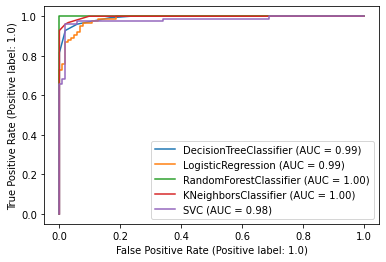

In [125]:
# Plotting ROC AUC curve on training data

disp = plot_roc_curve(dt,X_train,y_train)

plot_roc_curve(lr,X_train,y_train,ax=disp.ax_)

plot_roc_curve(rf,X_train,y_train,ax=disp.ax_)

plot_roc_curve(knn,X_train,y_train,ax=disp.ax_)

plot_roc_curve(svc,X_train,y_train,ax=disp.ax_)

plt.legend(prop={'size':10},loc='lower right')

plt.show()

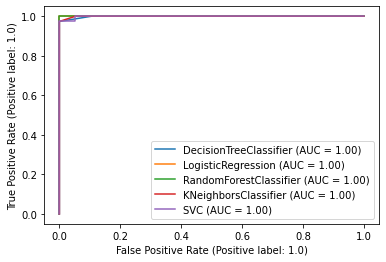

In [126]:
# Plotting ROC AUC curve on test data

disp = plot_roc_curve(dt,X_test,y_test)

plot_roc_curve(lr,X_test,y_test,ax=disp.ax_)

plot_roc_curve(rf,X_test,y_test,ax=disp.ax_)

plot_roc_curve(knn,X_test,y_test,ax=disp.ax_)

plot_roc_curve(svc,X_test,y_test,ax=disp.ax_)

plt.legend(prop={'size':10},loc='lower right')

plt.show()

# Best Model as per ROC AUC Curve

**The best performances are achieved by Random Forest and KNeighbors Classifier.** 

**All other models are also giving good result**

# Saving model in the pickle format

In [132]:
filename = 'glass_type.pkl'
pickle.dump(rf,open(filename,'wb'))

# Conclusion

In [133]:
loaded_model = pickle.load(open('glass_type.pkl','rb'))

pred_rf = loaded_model.predict(X_test)

result = accuracy_score(y_test,pred_rf)

print(result*100)

100.0


In [134]:
conclusion = pd.DataFrame([pred_rf,y_test],index=['Predicted','Original'])

In [135]:
conclusion

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
Predicted,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Original,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
